In [1]:
# import necessary package
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

In [2]:
# load example data
base_data = pd.read_csv('data_test_2010_to_2014.csv')

In [3]:
# pre-process
info_data = base_data.iloc[:,1:9]
feature_data = base_data.iloc[:,9:]
# get feature variables 
quant_features_b = feature_data.columns
print(quant_features_b)
# normalization
scaled_features_b = {}
for each in quant_features_b:
    mean, std = feature_data[each].mean(), feature_data[each].std()
    scaled_features_b[each] = [mean, std]
    feature_data.loc[:, each] = (feature_data[each] - mean)/std

Index(['mod09_b1', 'mod09_b2', 'mod09_b3', 'mod09_b4', 'b11', 'SWIR',
       'top_up_now', 'low_up_now', 'peak80_up_now', 'peak60_up_now',
       'peak40_up_now', 'peak20_up_now', 'los80_up_now', 'los60_up_now',
       'los40_up_now', 'los20_up_now', 'SW_in', 'GPP_VUT_NT', 'SW_GLASS'],
      dtype='object')


In [4]:
# set Plan B3
data_ann = feature_data.drop(['SW_in','GPP_VUT_NT','mod09_b3'],axis=1).values
# build ANN
input_size = data_ann.shape[1]
hidden_size = [18,9,3]
output_size = 1
batch_size = 128

class GPPNet(nn.Module):
    def __init__(self):
        super(GPPNet, self).__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size[0])
        self.layer2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.layer3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.out = nn.Linear(hidden_size[2], output_size)

    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        x = self.out(x)
        return x
# load Plan B3 ANN model    
neu = torch.load('ERSOD_Plan_B3.mdl')
# estimation
x =  torch.tensor(data_ann, dtype = torch.float, requires_grad = True)
predict = neu(x)
predict = predict.data.numpy()
mean, std = scaled_features_b['GPP_VUT_NT']
est = predict * std + mean

estimation_b3 = pd.DataFrame(est) # GPP_B_G_mGreen
estimation_b3.columns = ['GPP_Plan_B3']
estimation_b3.head()

,GPP_Plan_B3
0,7.916829
1,7.583105
2,6.660279
3,7.412223
4,7.388118


In [5]:
# export result
result = pd.concat([info_data,base_data['GPP_VUT_NT'],estimation_b3,
                    base_data['SW_GLASS'],base_data['SW_in']],axis = 1)
result.head()
#result.to_csv(r'result/ERSOD_Plan_B3.csv', index=False)

,year,month,day,site,DOY,lat,lon,type,GPP_VUT_NT,GPP_Plan_B3,SW_GLASS,SW_in
0,2010,1,1,AR-SLu,1,-33.4648,-66.4598,MF,11.1856,7.916829,342.31,392.221
1,2010,1,2,AR-SLu,2,-33.4648,-66.4598,MF,11.4885,7.583105,344.32,397.848
2,2010,1,4,AR-SLu,4,-33.4648,-66.4598,MF,11.3952,6.660279,355.16,387.215
3,2010,1,6,AR-SLu,6,-33.4648,-66.4598,MF,13.0215,7.412223,337.46,385.330
4,2010,1,7,AR-SLu,7,-33.4648,-66.4598,MF,11.9944,7.388118,334.42,370.611


<Figure size 1800x1200 with 0 Axes>

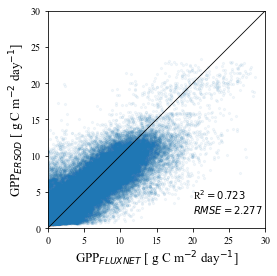

<Figure size 1800x1200 with 0 Axes>

In [6]:
Bias = result['GPP_VUT_NT'] - result['GPP_Plan_B3']
SE = np.square(Bias)
MSE = np.mean(SE)
RMSE = np.sqrt(MSE)
R2 = 1 - (np.var(Bias)/np.var(result['GPP_VUT_NT']))
# scatter plot
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.scatter(result['GPP_VUT_NT'], result['GPP_Plan_B3'], alpha = 1/20,s = 5)
plt.xlabel("GPP$_{FLUXNET}$"+" [ g C m$^{-2}$ day$^{-1}$]",size=13)
plt.ylabel("GPP$_{ERSOD}$"+" [ g C m$^{-2}$ day$^{-1}$]",size=13)
plt.axis('scaled')
plt.xlim(0,30)
plt.ylim(0,30)
plt.text(20,2,'$RMSE = %.3f$'% RMSE)
plt.text(20,4,'R$^{2}$'+'$ = %.3f$'% R2)
plt.plot([0,100],[0,100],'black',lw = 0.8)
plt.figure(dpi = 300)